In [7]:
import copy
import csv
import cvxpy
import datetime
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst.traces import philly
from skyburst.traces import philly_utils

In [8]:
jobs = philly.load_philly_traces('~/philly-traces/trace-data')
jobs.sort(key=lambda j: j._submitted_time)
all_jobs = jobs

/tmp/ipykernel_5551/164241561.py:7: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  dates_df["dates"] = dates_df["dates"].astype("datetime64")


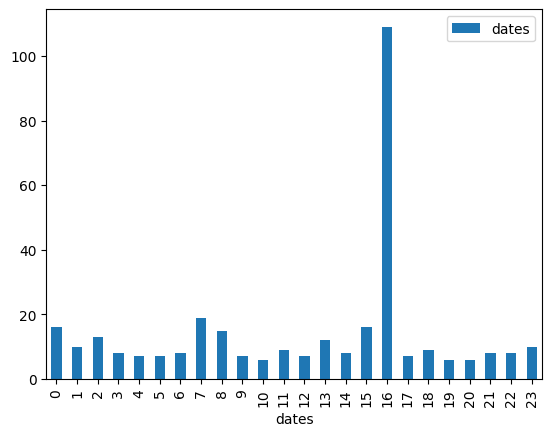

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


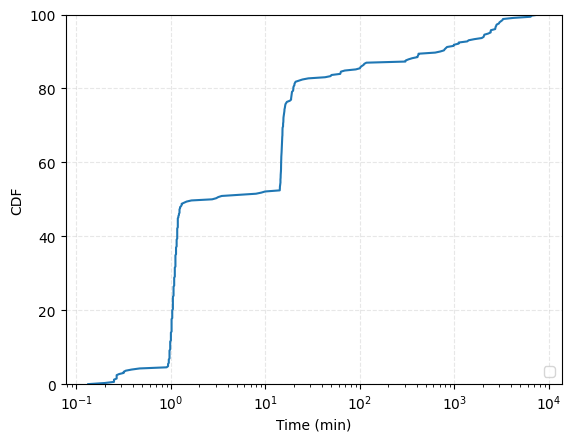

In [9]:
# Filter jobs based on Day
start_day = datetime.datetime(2017, 10, 7)
day_jobs = [j for j in jobs if (j._submitted_time - start_day).days ==0 and j._run_time is not None and j.status == 'Pass']
single_day_jobs = day_jobs
dates = [j._submitted_time for j in day_jobs]
dates_df = pd.DataFrame (dates, columns = ['dates'])
dates_df["dates"] = dates_df["dates"].astype("datetime64")
dates_df.groupby([dates_df["dates"].dt.hour]).count().plot(kind="bar")
plt.show()

# Plotting Job CDF for Phillly Trace
dayrun_times = []
for j in day_jobs:
    if j._run_time is not None and j.status=='Pass':
        dayrun_times.append(j._run_time)
dayrun_times.sort()
#print(run_times)

x, y = philly_utils.get_cdf(dayrun_times)
plt.plot(x, y)
plt.legend(loc='lower right')
plt.xscale('log')
#plt.xlim(10 ** -1, 8* 10 ** 4)
plt.ylim(0, 100)
plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.grid(alpha=.3, linestyle='--')
plt.show()

In [10]:
from math import floor, ceil

# Time Quantum Converter
# 6 seconds per time quantum (1 hr/600)
# Now at 6 minutes per time quantum
TIME_QUANTUM = 1/10.0

# Maximum job time in hours
CLIP_MAX_TIME = 1e9

# Deadline Multiplier d_t = a_t + K * r_t
DEADLINE_CONSTANT = 1.25

# Returns the deadline of a job.
# For continuous simulator
def deadline_mult_fn(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT):
    waiting_time = (deadline_mult - 1)*run_time
    waiting_time = max(1/12.0, waiting_time)
    return arrival_time + waiting_time + run_time

def deadline_ljw(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT, run_thres=8.0):
    if run_time < run_thres:
        return arrival_time + run_time
    waiting_time = (deadline_mult - 1)*run_time
    return arrival_time + waiting_time + run_time

def deadline_infinite_fn(arrival_time, run_time):
    return 1e12

def deadline_zero_fn(arrival_time, run_time):
    return arrival_time + run_time

# Returns the deadline of a job for discrete simulator
def deadline_discrete_fn(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT):
    quantized_arrival_time = ceil(arrival_time/TIME_QUANTUM)*TIME_QUANTUM
    quantized_gap = ceil(deadline_mult*run_time/TIME_QUANTUM)*TIME_QUANTUM
    return quantized_arrival_time + quantized_gap

def no_deadline_discrete_fn(arrival_time, run_time):
    quantized_arrival_time = ceil(arrival_time/TIME_QUANTUM)*TIME_QUANTUM
    quantized_gap = ceil(run_time/TIME_QUANTUM)*TIME_QUANTUM
    return quantized_arrival_time + quantized_gap

# Returns the total cost of a job.
def gpu_cost_fn(resources: dict, run_time: float):
    return resources['GPUs'] * run_time

def time_thres_fn(job, run_thres):
    return job.runtime >= run_thres

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

# Num nodes
NUM_NODES = 16

def preprocess_jobs(jobs: List['JobTrace'], deadline_fn= deadline_infinite_fn , cost_fn=gpu_cost_fn, clip_time: float = CLIP_MAX_TIME):
    """Converts a list of jobs into (arrival_time, run_time, deadline, resources, cost).
    """
    jobs = jobs.copy()
    # Remove invalid jobs (jobs that have not finished and jobs that failed/killed early)
    jobs = [j for j in jobs if j._run_time is not None and j.status=='Pass']
    jobs.sort(key=lambda j: j._submitted_time)
    
    if not clip_time:
        clip_time = 1e9
    
    # Arrival time for jobs
    start_time = jobs[0]._submitted_time
    arrival_times = [(j._submitted_time- start_time).total_seconds()/3600.0 for j in jobs]
    
    # Run time for jobs
    run_times = []
    for j in jobs:
        # Clip the maximum run time for jobs to simplify simulation.
        run_time_hr = j._run_time/60.0
        if run_time_hr > clip_time:
            run_times.append(clip_time)
        else:
            run_times.append(run_time_hr)
    
    deadlines = [deadline_fn(arrival, run) for arrival, run in zip(arrival_times, run_times)]
    
    # Get GPU resources
    resources = []
    for j in jobs:
        detail_dict = j.attempts[-1]['detail']
        gpu_count = sum([len(node_dict['gpus']) for node_dict in detail_dict])
        resources.append({'GPUs': gpu_count})
    
    costs = [cost_fn(res, run) for res, run in zip(resources, run_times)]
    
    return [Job(idx, arr, run, dead, res, cost) \
            for idx, (arr, run, dead, res, cost) in \
            enumerate(list(zip(arrival_times, run_times, deadlines, resources, costs)))]

def generate_philly_jobs(jobs: List['JobTrace'], num_jobs = 1e6, deadline_fn= deadline_infinite_fn , cost_fn=gpu_cost_fn, clip_time: float = CLIP_MAX_TIME):
    """Converts a list of jobs into (arrival_time, run_time, deadline, resources, cost).
    """
    num_jobs = int(num_jobs)
    jobs = jobs.copy()
    # Remove invalid jobs (jobs that have not finished and jobs that failed/killed early)
    jobs = [j for j in jobs if j._run_time is not None and j.status=='Pass']
    jobs.sort(key=lambda j: j._submitted_time)
    
    if not clip_time:
        clip_time = 1e9
    
    # Arrival time for jobs
    start_time = jobs[0]._submitted_time
    arrival_times = [(j._submitted_time- start_time).total_seconds()/3600.0 for j in jobs]

    interarrival_times = [arrival_times[i+1]-arrival_times[i] for i in range(len(arrival_times)-1)]
    
    # Run time for jobs
    run_times = []
    for j in jobs:
        # Clip the maximum run time for jobs to simplify simulation.
        run_time_hr = j._run_time/60.0
        if run_time_hr > clip_time:
            run_times.append(clip_time)
        else:
            run_times.append(run_time_hr)

    # Get GPU resources
    resources = []
    for j in jobs:
        detail_dict = j.attempts[-1]['detail']
        gpu_count = sum([len(node_dict['gpus']) for node_dict in detail_dict])
        resources.append({'GPUs': gpu_count})
    
    import random
    sampled_arrival_times = np.random.choice(interarrival_times, size=num_jobs, replace=True)
    job_indexes = np.random.choice(list(range(len(run_times))), size=num_jobs, replace=True)
    proc_jobs = []
    arrival_time = 0 
    for idx in range(num_jobs):
        job_idx = job_indexes[idx]
        runtime = run_times[job_idx]
        deadline = deadline_fn(arrival_time, runtime)
        cost = cost_fn(resources[job_idx], runtime)
        proc_jobs.append(Job(idx, arrival_time, runtime, deadline, resources[job_idx], cost))
        arrival_time += sampled_arrival_times[idx]
    
    return proc_jobs

In [11]:
class Node(object):
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.gpu_dict = {}
        for idx in range(self.num_gpus):
            self.gpu_dict[idx] = None
    
    def free_gpus(self):
        return len([v for v in self.gpu_dict.values() if not isinstance(v, Job)])
    
    def try_fit(self, cur_timestamp, job, num_gpus=None):
        gpu_list = []
        if num_gpus==None:
            num_gpus = job.resources['GPUs']

        if num_gpus > self.free_gpus():
            return False, gpu_list

        counter =0
        for idx in range(self.num_gpus):
            gpu_val = self.gpu_dict[idx]
            if not isinstance(gpu_val, Job):
                self.gpu_dict[idx] = job
                gpu_list.append(idx)
                counter +=1
            if counter >= num_gpus:
                break
        return True, gpu_list
    
    def __repr__(self):
        return f'{self.gpu_dict}'        
        

class Cluster(object):
    
    def __init__(self, num_nodes, num_gpus_per_node, preempt=None, reserve=False):
        self.num_nodes = num_nodes
        self.num_gpus_per_node = num_gpus_per_node
        self.nodes = [Node(num_gpus_per_node) for _ in range(num_nodes)]
        self.preempt = preempt
        self.reserve = reserve
        self.active_jobs = {}
    
    def is_full(self):
        for n in self.nodes:
            for gpu_idx in n.gpu_dict:
                if not n.gpu_dict[gpu_idx]:
                    return False
        return True
    
    def try_fit_v2(self, cur_timestamp, job):
        num_gpus = job.resources['GPUs']
                        
        # Generate Plan
        free_gpus = [n.free_gpus() for n in self.nodes]
        free_plus_preempted_gpus = free_gpus.copy()
        node_idx_to_pre_job = {}
        
        # Logic to pre-empt GPU(s). Generates candidates jobs to be pre-empted on the cluster.
        preemptible_jobs = []
        if self.preempt:
            C = 1.0/self.preempt - 1.0
            for j_idx, j in self.active_jobs.items():
                # Filter for jobs that will not exceed deadline (if preempted)
                if j.deadline - j.runtime > cur_timestamp and job.runtime > j.runtime:
                    # job.cost - j.cost >= j.opp_cost:
                    factor = 0
                    if j.num_gpus > job.num_gpus:
                        factor = (1 - (job.num_gpus/j.num_gpus))*job.runtime
                    if j.num_gpus ==0:
                        continue
                    if job.runtime - j.runtime >= C * (cur_timestamp - j.start) + factor + j.opp_cost/(self.preempt*j.num_gpus):
                        preemptible_jobs.append(j)                  
            preemptible_jobs.sort(key=lambda x: x.cost)
        
        # No hope of fitting onto cluster :(
        if num_gpus > sum(free_plus_preempted_gpus):
            return False, []
        
        # Generate job GPU demands
        if num_gpus > self.num_gpus_per_node:
            # Multinode case, i.e. 26 GPUs, 8 GPU/node cluster -> job_gpu_demands = [8,8,8,2]
            job_gpu_demands = [self.num_gpus_per_node]*int(num_gpus/self.num_gpus_per_node)
            if num_gpus%self.num_gpus_per_node:
                job_gpu_demands.append(num_gpus%self.num_gpus_per_node)
        else:
            job_gpu_demands = [num_gpus]

        # Generate Plans - which nodes to place job on and which jobs to preempt
        # Maps node idx to gpu_demand
        node_idx_taken = {}
        # Maps node idx to (gpu_demand, list of job idx of preempted jobs on that node)
        preempted_idx_taken = {}
        remove_idx = []
        
        # Go through free space only first, generate partial plan with free space
        for list_idx, gpu_demand in enumerate(list(job_gpu_demands)):
            for n_idx, n in enumerate(self.nodes):
                if n_idx in node_idx_taken:
                    continue
                if free_gpus[n_idx] >= gpu_demand:
                    node_idx_taken[n_idx] = gpu_demand
                    job_gpu_demands.remove(gpu_demand)
                    break

        # Go through premptible jobs to find more space, generate final plan
        if self.preempt and job_gpu_demands:
            temp_free_gpus = free_gpus.copy()
            preemptible_jobs_to_node = [[] for _ in range(self.num_nodes)]
            for pre_j in preemptible_jobs:
                for n_idx, n_gpu_list in pre_j.allocated_gpus.items():
                    temp_free_gpus[n_idx] += len(n_gpu_list)
                    preemptible_jobs_to_node[n_idx].append(pre_j)
                
                for list_idx, gpu_demand in enumerate(list(job_gpu_demands)):
                    for n_idx, n in enumerate(self.nodes):
                        if n_idx in node_idx_taken or n_idx in preempted_idx_taken:
                            continue
                        if temp_free_gpus[n_idx] >= gpu_demand:
                            preempted_idx_taken[n_idx] = (gpu_demand, [j.idx for j in preemptible_jobs_to_node[n_idx]]) 
                            job_gpu_demands.remove(gpu_demand)
                            break
                
                if not job_gpu_demands:
                    break
            
        # If there are still demands that cannot be satisifed via free and preempted jobs,
        # it cannot be scheduled on the cluster.
        if job_gpu_demands:
            return False, []
        
        # Execute plan
        preempted_jobs = []
        # Populate nodes that enough free gpus
        for n_idx, gpu_demand in node_idx_taken.items():
            gpu_list = self.try_fit_node(self.nodes[n_idx], cur_timestamp, job, num_gpus=gpu_demand)
            job.allocated_gpus[n_idx] = gpu_list
        
        if self.preempt:
            # Poppulate nodes that need jobs preempted first
            buffer = []
            for n_idx, job_tuple in preempted_idx_taken.items():
                gpu_demand, preempted_job_idxs = job_tuple
                for job_idx in preempted_job_idxs:
                    if job_idx in buffer:
                        continue
                    pre_job = self.active_jobs[job_idx]
                    job.opp_cost += (cur_timestamp - pre_job.start) * pre_job.num_gpus
                    preempted_job = self.preempt_job(job_idx)
                    preempted_jobs.append(preempted_job)
                    buffer.append(job_idx)
                gpu_list = self.try_fit_node(self.nodes[n_idx], cur_timestamp, job, num_gpus=gpu_demand)
                job.allocated_gpus[n_idx] = gpu_list
        
        job.start = cur_timestamp
        self.active_jobs[job.idx] = job
        
        return True, preempted_jobs
    
    def try_fit_node(self, node, cur_timestamp, job, num_gpus=None):
        gpu_list = []
        if num_gpus==None:
            num_gpus = job.resources['GPUs']

        if num_gpus > node.free_gpus():
            raise ValueError("Should not go here in try_fit_node!")

        counter =0
        for idx in range(node.num_gpus):
            gpu_val = node.gpu_dict[idx]
            if not isinstance(gpu_val, Job):
                node.gpu_dict[idx] = job
                gpu_list.append(idx)
                counter +=1
            if counter >= num_gpus:
                break
        return gpu_list
    
    def preempt_job(self, job_idx):
        assert job_idx in self.active_jobs
        r_job = self.active_jobs[job_idx]
        for n_idx, gpu_list in r_job.allocated_gpus.items():
            node = self.nodes[n_idx]
            for gpu_idx in gpu_list:
                node.gpu_dict[gpu_idx] = None
        r_job.start = None
        r_job.allocated_gpus = {}
        del self.active_jobs[job_idx]
        return r_job
            
    def try_clear(self, t: float):
        """Clears cluster of completed jobs.
        """
        completed_jobs = []
        for job_idx, job in self.active_jobs.items():
            if t >= job.start + job.runtime:
                node_gpu_dict = job.allocated_gpus
                for node_idx, gpu_list in node_gpu_dict.items():
                    node_gpu_dict = self.nodes[node_idx].gpu_dict
                    for gpu_idx in gpu_list:
                        node_gpu_dict[gpu_idx] = None
                completed_jobs.append(job)
        
        for job in completed_jobs:
            job.state = 'LOCAL'
            del self.active_jobs[job.idx]
        return completed_jobs
    
    def __repr__(self):
        repr_str = 'Cluster State:\n'
        for idx, n in enumerate(self.nodes):
            repr_str += f'Node {idx}: {n}\n'
        return repr_str



In [12]:
## Attempt Pre-emption
# Add job into the cluster -> pre empt jobs (what jobs to preempt?)
# Only preempt jobs that have reached deadline & are cheaper than the current job
# Preempted jobs go back into the queue
# Warning very slow!
def continuous_simulator(jobs: List[Job], policy, num_nodes, job_filter_policy=None, preempt=None, reserve=False, verbose=False, debug=False):
    if '-' in policy:
        policy, mod = policy.split('-')
    else:
        mod = None
    
    if policy == 'fifo':
        sort_func = lambda x: x.arrival
    elif policy == 'lifo':
        sort_func = lambda x: -x.arrival
    elif policy == 'edf':
        sort_func = lambda x: x.deadline
    elif policy == 'ldf':
        sort_func = lambda x: -x.deadline
    elif policy == 'sjf':
        sort_func = lambda x: x.runtime
    elif policy == 'svjf':
        sort_func = lambda x: x.cost
    elif policy == 'ljf':
        sort_func = lambda x: -x.runtime
    elif policy == 'lvjf':
        sort_func = lambda x: -x.cost
    elif policy == 'swf':
        sort_func = lambda x: x.deadline - x.runtime 
    elif policy == 'lwf':
        sort_func = lambda x: -x.deadline + x.runtime
    else:
        pass
        #raise ValueError(f'Policy {policy} does not match!')
    
    remove_hol = False
    if mod == 'nohol':
        remove_hol = True
    
    job_filter_fn = None
    if job_filter_policy is not None:
        job_filter_policy, run_thres = job_filter_policy.split('-')
        if job_filter_policy == 'ljw':
            job_filter_fn = lambda x: time_thres_fn(x, float(run_thres))
        else:
            raise ValueError(f'Incorrect job filter policy {job_filter_policy}.')
    finished_jobs = []
    jobs = copy.deepcopy(jobs)
    num_jobs = len(jobs)

    queue = []
    cloud_cost = 0
    cluster = Cluster(num_nodes=num_nodes, num_gpus_per_node=GPUS_PER_NODE, preempt=preempt, reserve=reserve)
    t=0
    while len(jobs) >0 or len(queue)>0:
        # Clear cluster of jobs that have completed
        finished_jobs.extend(cluster.try_clear(t))
        
        # Check for jobs that have waited too long (move to cloud).
        for job in queue[:]:
            if t >= job.deadline - job.runtime:
                queue.remove(job)
                job.state = 'TIMEOUT-CLOUD'
                job.start = job.deadline - job.runtime
                finished_jobs.append(job)
        
        # Add jobs to queue that have arrived
        for job in jobs[:]:
            if job.arrival < t:
                raise ValueError("Should not have entered here!")
                
            if job.arrival == t:
                jobs.remove(job)
                if job_filter_fn is not None:
                    # If arrival job does not satisfy job filter, move job to cloud.
                    if not job_filter_fn(job):
                        job.state = 'FILTER-CLOUD'
                        finished_jobs.append(job)
                        continue
                queue.append(job)
            else:
                break
        queue.sort(key = sort_func)
        
        # Go through queue and fit jobs onto cluster as needed
        preempted_jobs = []
        for job in queue[:]:
            can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
            if can_fit:
                queue.remove(job)
                queue.extend(preempted_jobs)
            elif not remove_hol:
                break
        
        next_time_list = []
        
        # Skip to next timestep where a new job either arrives or when a job finishes on the cluster.
        for job_idx, job in cluster.active_jobs.items():
            release_time = job.start + job.runtime
            next_time_list.append(release_time)

        if len(jobs)>0:
            next_time_list.append(jobs[0].arrival)
        
        if len(next_time_list)==0:
            assert len(queue)==0 and len(jobs) ==0
            break
        
        if min(next_time_list) < t:
            raise ValueError('Simulator is severely bugged; Raise a Git Issue.')
                
        if verbose or debug:
            print(f'Timestamp: {t}')
            print(f'Jobs left: {len(jobs)}')
            print(f'Cloud Cost: {cloud_cost}')
            print(cluster)
            print('Queue: ' + str(queue) + '\n')
            print('Finished Jobs: ' + str(finished_jobs) + '\n')
            if debug:
                import pdb; pdb.set_trace()
        
        t = min(next_time_list)
    finished_jobs.extend(cluster.try_clear(1e12))
    assert len(jobs)==0 and len(queue)==0

    # Compute Avg. Waiting Time
    total_waiting_time = 0.0
    num_jobs = 0
    for job in finished_jobs:
        # remove warmup and cooldown period
        if job.idx < 2000 or job.idx > len(finished_jobs)-2000:
            continue
        # Moved to cloud
        if job.state != 'LOCAL':
            if job.state == 'TIMEOUT-CLOUD':
                total_waiting_time += job.deadline - job.runtime - job.arrival
            elif job.state == 'FILTER-CLOUD':
                pass
            else:
                raise ValueError('Invalid State!')
            cloud_cost += job.cost
        else:
            assert job.state == 'LOCAL'
            total_waiting_time += job.start - job.arrival
        num_jobs+=1
    

    print(f'{policy}-{num_nodes}')
    print(f'Cloud Cost ({policy}-{num_nodes}): {cloud_cost}')
    print(f'Avg Waiting Time ({policy}-{num_nodes}): {total_waiting_time/num_jobs}')
    print(len(finished_jobs))
    return f'{policy}-{num_nodes}', save_simulator_results(finished_jobs)

def save_simulator_results(finished_jobs: List[Job]) -> dict:
    result_dict = {
        'idx': [],
        'arrival': [],
        'start': [],
        'runtime': [],
        'deadline': [],
        'num_gpus': [],
        'state': [],
        'allocated_gpus': [],
    }
    finished_jobs.sort(key = lambda x: x.idx)
    for job in finished_jobs:
        result_dict['idx'].append(job.idx)
        result_dict['arrival'].append(job.arrival)
        result_dict['start'].append(job.start)
        result_dict['runtime'].append(job.runtime)
        result_dict['deadline'].append(job.deadline)
        result_dict['num_gpus'].append(job.num_gpus)
        result_dict['state'].append(job.state)
        result_dict['allocated_gpus'].append(job.allocated_gpus)
    result_dict['idx'] = np.array(result_dict['idx'])
    result_dict['arrival'] = np.array(result_dict['arrival'])
    result_dict['start'] = np.array(result_dict['start'])
    result_dict['runtime'] = np.array(result_dict['runtime'])
    result_dict['deadline'] = np.array(result_dict['deadline'])
    result_dict['num_gpus'] = np.array(result_dict['num_gpus'])
    result_dict['state'] = np.array(result_dict['state'])
    result_dict['allocated_gpus'] = np.array(result_dict['allocated_gpus'])
    return result_dict

In [7]:
# def continuous_hyperparameter_search(jobs, algs, nodes_list, deadline_fn, job_filter_policy=None, preempt=None, remove_hol=False):
#     jobs_proc = generate_philly_jobs(jobs, num_jobs=1000000, deadline_fn=deadline_fn)
#     tuples = []
#     for n_nodes in nodes_list:
#         for alg in algs:
#             tuples.append((jobs_proc, alg, n_nodes, job_filter_policy, preempt, remove_hol))
#     results = []
#     with multiprocessing.Pool(processes=63) as pool:
#         results = pool.starmap(continuous_simulator, tuples)
#     results_dict = {}
#     for r in results:
#         results_dict[r[0]] = r[1]
#     return results_dict


# ajw_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, deadline_infinite_fn)
# file = open('logs/ajw_philly_cont.log', 'wb')
# pickle.dump(ajw_results, file)
# file.close()

# njw_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, deadline_zero_fn)
# file = open('logs/njw_philly_cont.log', 'wb')
# pickle.dump(njw_results, file)
# file.close()

# num_nodes = list(range(24, 150, 4))
# algs = ['fifo', 'lifo', 'sjf', 'svjf', 'ljf', 'lvjf', 'edf', 'ldf', 'swf', 'lwf']
# for ddl in [1, 1.1, 1.25, 1.5]:
#     if ddl==1:
#         temp_fn = deadline_zero_fn
#     elif ddl == 100000:
#         temp_fn = deadline_infinite_fn
#     else:
#         temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
#     hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                       deadline_fn=temp_fn)
#     file = open(f'logs/generated/vjw_philly_{ddl}_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()

temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=1.25)
jobs_proc = preprocess_jobs(all_jobs, deadline_fn=temp_fn)

asdf = continuous_simulator(jobs_proc, 'swf', 72)
asdf1 = continuous_simulator(jobs_proc, 'fifo', 72)
asdf2 = continuous_simulator(jobs_proc, 'lifo', 72)
#asdf1 = continuous_simulator(jobs_proc, 'swf-nohol', 72)
# asdf1 = continuous_simulator(jobs_proc, 'sjf', 72)

# #asdf1 = continuous_simulator(jobs_proc, 'fifo', 72, asdf=True)#job_filter_policy='ljw-1')

swf-72
Cloud Cost (swf-72): 143791.82555555573
Avg Waiting Time (swf-72): 0.43325693961915684
83154
fifo-72
Cloud Cost (fifo-72): 163294.55166666757
Avg Waiting Time (fifo-72): 0.38204651387208816
83154
lifo-72
Cloud Cost (lifo-72): 166528.94722222287
Avg Waiting Time (lifo-72): 0.19534503154854882
83154


83154


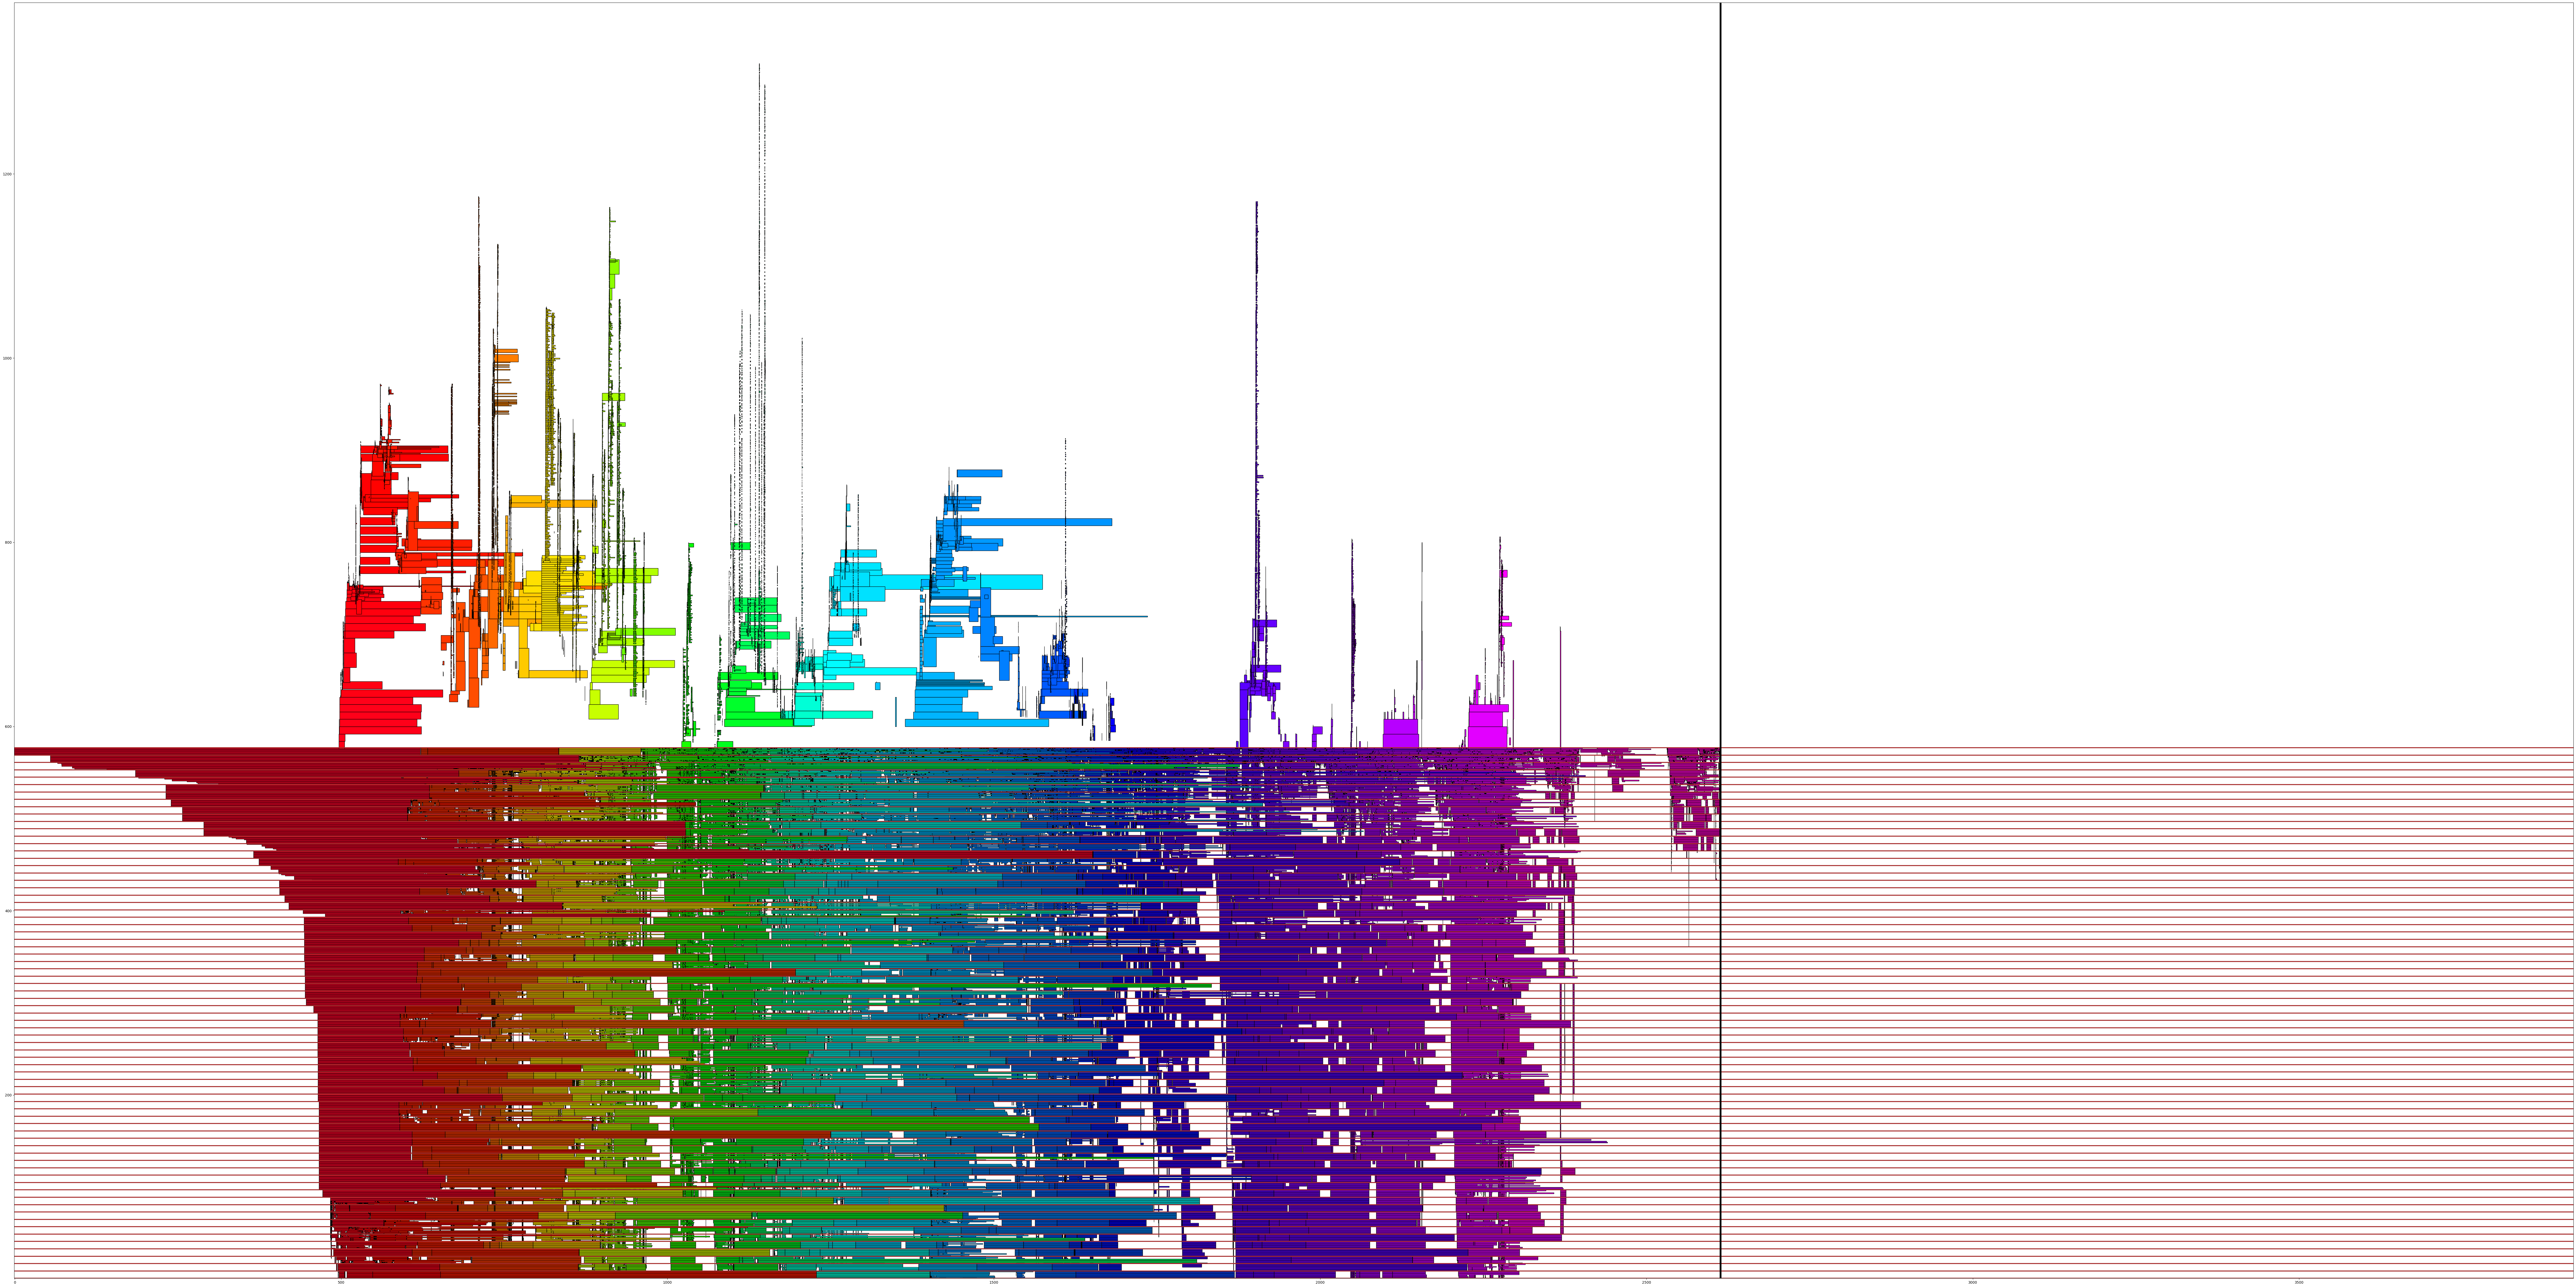

In [21]:
def plot_trace_spacetime(jobs, num_nodes, filter_range=None):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs['idx'])
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)]
    #jobs.sort(key=lambda x: x.idx)
    fig, ax = plt.subplots(figsize=(100, 50))
    total_gpus = num_nodes * GPUS_PER_NODE
    print(len(jobs['idx']))
    segment_height_list = {}
    for j_idx in range(len(jobs['idx'])):
        allocated_gpus = jobs['allocated_gpus'][j_idx]
        if not allocated_gpus:
            height = 0
            segment = (jobs['arrival'][j_idx], jobs['arrival'][j_idx] + jobs['runtime'][j_idx], j_idx)
            for k,v in segment_height_list.items():
                if segment[0] > k[0] and segment[0] < k[1]:
                    height += v
            segment_height_list[segment] = jobs['num_gpus'][j_idx]
            ax.barh(total_gpus + height,
                            width=segment[1] - segment[0],
                            edgecolor='black',
                            height=jobs['num_gpus'][j_idx],
                            left=segment[0],
                            align='edge',
                            color=colors[jobs['idx'][j_idx]])
        else:
            for node_idx in allocated_gpus.keys():
                for node_gpu_idx in allocated_gpus[node_idx]:
                    gpu_idx = total_gpus - (GPUS_PER_NODE * node_idx +
                                            node_gpu_idx)
                    #                 print(job.idx)
                    #                 print(len(colors))
                    ax.barh(gpu_idx,
                            width=jobs['runtime'][j_idx],
                            edgecolor='black',
                            height=1.0,
                            left=jobs['start'][j_idx],
                            align='edge',
                            color=colors[jobs['idx'][j_idx]])
    import math
    for i in range(total_gpus + 1):
        multiplier = math.ceil(num_nodes / 32)
        if (i + 1) % GPUS_PER_NODE == 1:
            plt.axhline(y=i + 1, linewidth=8 / multiplier, color='brown')
        else:
            pass
#             plt.axhline(y=i + 1,
#                         linewidth=1 / multiplier,
#                         color='black',
#                         linestyle='--')
    max_arrival = max(jobs['arrival'])
    plt.ylim(bottom=1)#, #top=total_gpus + 1)
    plt.xlim(right=1.5 * max_arrival)
    plt.axvline(x=max_arrival, color='black', linewidth=5)
    plt.tight_layout()
    plt.show()
plot_trace_spacetime(asdf[1], 72)

In [13]:
algs = ['fifo', 'lifo', 'sjf', 'svjf', 'ljf', 'lvjf', 'edf', 'ldf', 'swf', 'lwf']

#num_nodes = [72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136] #[105, 110, 120, 125]
num_nodes = list(range(24, 150, 4))

def continuous_hyperparameter_search(jobs, algs, nodes_list, deadline_fn, job_filter_policy=None, preempt=None, remove_hol=False):
    jobs_proc = preprocess_jobs(jobs, deadline_fn=deadline_fn)
    tuples = []
    for n_nodes in nodes_list:
        for alg in algs:
            tuples.append((jobs_proc, alg, n_nodes, job_filter_policy, preempt, remove_hol))
    results = []
    with multiprocessing.Pool(processes=63) as pool:
        results = pool.starmap(continuous_simulator, tuples)
    results_dict = {}
    for r in results:
        results_dict[r[0]] = r[1]
    return results_dict


# ajw_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, deadline_infinite_fn)
# file = open('logs/ajw_philly_cont.log', 'wb')
# pickle.dump(ajw_results, file)
# file.close()

# njw_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, deadline_zero_fn)
# file = open('logs/njw_philly_cont.log', 'wb')
# pickle.dump(njw_results, file)
# file.close()

algs = [alg for alg in algs]
print(algs)
for ddl in [1, 1.25]:
    if ddl==1:
        temp_fn = deadline_zero_fn
    elif ddl == 100000:
        temp_fn = deadline_infinite_fn
    else:
        temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
    hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
                                                      deadline_fn=temp_fn)
    file = open(f'logs/none_old/vjw_philly_{ddl}_cont.log', 'wb')
    pickle.dump(hybrid_results, file)
    file.close()


# for ddl in [1, 1.1, 1.25, 1.5, 2, 100000]:
#     if ddl==1:
#         temp_fn = deadline_zero_fn
#     elif ddl == 100000:
#         temp_fn = deadline_infinite_fn
#     else:
#         temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
#     hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                       deadline_fn=temp_fn)
#     file = open(f'logs/base/vjw_philly_{ddl}_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()

# for ddl in [1.5]:
#     for preempt_thres in [1/10.0, 1/8.0, 1/5.0, 1/2.0]:
#         temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
#         hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                           deadline_fn=temp_fn, preempt=preempt_thres)
#         file = open(f'logs/vjw_philly_{ddl}_preempt_{preempt_thres}_cont.log', 'wb')
#         pickle.dump(hybrid_results, file)
#         file.close()

# def deadline_ljw(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT, run_thres=8.0):
#     if run_time < run_thres:
#         return arrival_time + run_time
#     waiting_time = (deadline_mult - 1)*run_time
#     return arrival_time + waiting_time + run_time
# for run_thres in [1]:
#     for ddl in [1.5]:
#         temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
#         hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                           deadline_fn=temp_fn, job_filter_policy = f'ljw-{run_thres}')
#         file = open(f'logs/vjw_philly_{ddl}_{run_thres}_cont.log', 'wb')
#         pickle.dump(hybrid_results, file)
#         file.close()



['fifo', 'lifo', 'sjf', 'svjf', 'ljf', 'lvjf', 'edf', 'ldf', 'swf', 'lwf']
sjf-28
Cloud Cost (sjf-28): 684392.3844444407
Avg Waiting Time (sjf-28): 4.59601895912035e-17
83154
swf-24
Cloud Cost (swf-24): 726256.931666663
Avg Waiting Time (swf-24): 4.7396445515928606e-17
83154
ljf-24
Cloud Cost (ljf-24): 729023.2444444427
Avg Waiting Time (ljf-24): 4.7396445515928606e-17
83154
edf-24
Cloud Cost (edf-24): 725688.180277775
Avg Waiting Time (edf-24): 4.452393366647839e-17
83154
edf-64
Cloud Cost (edf-64): 314313.62972222216
Avg Waiting Time (edf-64): 8.617535548350656e-18
83154
sjf-24
Cloud Cost (sjf-24): 725688.180277775
Avg Waiting Time (sjf-24): 4.452393366647839e-17
83154
swf-28
Cloud Cost (swf-28): 683418.884166662fifo-32

Avg Waiting Time (swf-28): 4.308767774175328e-17Cloud Cost (fifo-32): 635927.4869444416

83154
Avg Waiting Time (fifo-32): 2.7288862569777077e-17
83154
fifo-24
Cloud Cost (fifo-24): 726370.3602777738
Avg Waiting Time (fifo-24): 4.7396445515928606e-17
83154
ljf-36
Clo

Process ForkPoolWorker-49:
Process ForkPoolWorker-44:
Process ForkPoolWorker-46:
Process ForkPoolWorker-38:
Process ForkPoolWorker-59:
Process ForkPoolWorker-56:
Process ForkPoolWorker-41:
Process ForkPoolWorker-39:
Process ForkPoolWorker-60:
Process ForkPoolWorker-63:
Process ForkPoolWorker-43:
Process ForkPoolWorker-62:
Process ForkPoolWorker-57:
Process ForkPoolWorker-48:
Process ForkPoolWorker-53:
Process ForkPoolWorker-36:
Process ForkPoolWorker-55:
Process ForkPoolWorker-47:
Process ForkPoolWorker-45:
Process ForkPoolWorker-51:
Process ForkPoolWorker-58:
Process ForkPoolWorker-61:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 315, in _bootst

  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-26:
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-30:
Process ForkPoolWorker-10:
Process ForkPoolWorker-24:
Process ForkPoolWorker-21:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Process ForkPoolWorker-18:
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-40:
Process ForkPoolWorker-28:
Process ForkPoolWorker-27:
Process ForkPoolWorker-42:
Traceback (mo

  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/tmp/ipykernel_5551/610846602.py", line 88, in continuous_simulator
    can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
KeyboardInterrupt
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
KeyboardInterrupt
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/tmp/ipykernel_5551/610846602.py", line 68, in continuous_simulator
    for job in jobs[:]:
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 

KeyboardInterrupt
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  

  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/envs/sky/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/envs/sky/lib/python3.9/multipr

  File "/tmp/ipykernel_5551/610846602.py", line 99, in continuous_simulator
    release_time = job.start + job.runtime
  File "/tmp/ipykernel_5551/610846602.py", line 82, in continuous_simulator
    break
  File "/tmp/ipykernel_5551/610846602.py", line 68, in continuous_simulator
    for job in jobs[:]:
KeyboardInterrupt
  File "/tmp/ipykernel_5551/610846602.py", line 68, in continuous_simulator
    for job in jobs[:]:
  File "/tmp/ipykernel_5551/610846602.py", line 68, in continuous_simulator
    for job in jobs[:]:
  File "/tmp/ipykernel_5551/610846602.py", line 82, in continuous_simulator
    break
KeyboardInterrupt
  File "/tmp/ipykernel_5551/610846602.py", line 88, in continuous_simulator
    can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
  File "/tmp/ipykernel_5551/610846602.py", line 68, in continuous_simulator
    for job in jobs[:]:
  File "/tmp/ipykernel_5551/610846602.py", line 68, in continuous_simulator
    for job in jobs[:]:
  File "/tmp/ipykernel_5551/2051162486.p

KeyboardInterrupt: 

In [ ]:
def discrete_simulator(jobs: List[Job], policy, num_nodes, preempt=False, reserve=False, verbose=False, debug=False):
    if policy=='fifo':
        sort_func = lambda x: x.arrival
    elif policy == 'edf':
        sort_func = lambda x: x.deadline
    elif policy == 'sjf':
        sort_func = lambda x: x.runtime
    elif policy == 'svjf':
        sort_func = lambda x: x.cost
    elif policy == 'ljf':
        sort_func = lambda x: -x.runtime
    elif policy == 'lvjf':
        sort_func = lambda x: -x.cost
    else:
        raise ValueError(f'Policy {policy} does not match!')

    jobs = copy.deepcopy(jobs)
    num_jobs = len(jobs)
    finished_jobs = []
    queue = []
    cloud_cost = 0
    cluster = Cluster(num_nodes=num_nodes, num_gpus_per_node=GPUS_PER_NODE, preempt=preempt, reserve=reserve)
    t=0
    while len(jobs) >0 or len(queue)>0:
        #print(t)
        next_time_list = []
        # Clear cluster of jobs that have completed
        finished_jobs.extend(cluster.try_clear(t))
        
        # Check for jobs that have waited too long (move to cloud).
        for job in queue[:]:
            if t >= job.deadline - job.runtime:
                queue.remove(job)
                finished_jobs.append(job)
                cloud_cost += job.cost
        
        # Add jobs to queue that have arrived
        for job in jobs[:]:
            if job.arrival < t - TIME_QUANTUM:
                raise ValueError('Should have added long ago!')
            elif job.arrival <= t:
                jobs.remove(job)
                queue.append(job)
            else:
                break
        
        if cluster.is_full():
            t+= TIME_QUANTUM
            continue
                
        # Sort queue based on heuristic
        queue.sort(key = sort_func)
        
        # Go through queue and fit jobs onto cluster as needed
        preempted_jobs = []
        for job in queue[:]:
            can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
            if can_fit:
                queue.remove(job)
                queue.extend(preempted_jobs)
            #break

        if verbose or debug:
            print(f'Timestamp: {t}')
            print(f'Jobs left: {len(jobs)}')
            print(f'Cloud Cost: {cloud_cost}')
            print(cluster)
            print('Queue: ' + str(queue) + '\n')
            print('Finished Jobs: ' + str(finished_jobs) + '\n')
            if debug:
                import pdb; pdb.set_trace()
        
        t += TIME_QUANTUM
    finished_jobs.extend(cluster.try_clear(1e12))
    # Compute Avg. Waiting Time
    total_waiting_time = 0.0
    for job in finished_jobs:
        # Moved to cloud
        if job.start is None:
            total_waiting_time += job.deadline - job.runtime - job.arrival
        else:
            total_waiting_time += job.start - job.arrival
    
    print(f'{policy}-{num_nodes}')
    print(f'Cloud Cost ({policy}-{num_nodes}): {cloud_cost}')
    print(f'Avg Waiting Time ({policy}-{num_nodes}): {total_waiting_time/len(finished_jobs)}')
    return f'{policy}-{num_nodes}', finished_jobs

def discrete_hyperparameter_search(jobs, algs, nodes_list, deadline_fn):
    jobs_proc = preprocess_jobs(jobs, deadline_fn=deadline_fn)
    tuples = []
    for n_nodes in nodes_list:
        for alg in algs:
            tuples.append((jobs_proc, alg, n_nodes))

    with multiprocessing.Pool(processes=31) as pool:
        results = pool.starmap(discrete_simulator, tuples)
    
    results_dict = {}
    for r in results:
        results_dict[r[0]] = r[1]
    return results_dict

ajw_results = discrete_hyperparameter_search(all_jobs, algs, num_nodes, deadline_infinite_fn)
file = open('logs/ajw_philly_discrete.log', 'wb')
pickle.dump(ajw_results, file)
file.close()

njw_results = discrete_hyperparameter_search(all_jobs, algs, num_nodes, no_deadline_fn)
file = open('logs/njw_philly_discrete.log', 'wb')
pickle.dump(njw_results, file)
file.close()

for ddl in [1.25, 1.5, 2, 5]:
    temp_fn = lambda x, y: deadline_discrete_fn(x,y,deadline_mult=ddl)
    hybrid_results = discrete_hyperparameter_search(all_jobs, algs, num_nodes, deadline_fn=temp_fn)
    file = open(f'logs/vjw_philly_{ddl}_discrete.log', 'wb')
    pickle.dump(hybrid_results, file)
    file.close()

In [ ]:
jobs_proc = preprocess_jobs(jobs, deadline_fn=temp_fn)
jobs_proc = jobs_proc[10000:10200]
node = 8

def milp_solver_v3(jobs: List[Job], nodes, prefill=None):
    import cvxpy
    import numpy as np
    bin_width = GPUS_PER_NODE
    bin_height = 1e6
    num_jobs = len(jobs)
    arrivals = np.array([j.arrival for j in jobs])
    runtimes = np.array([j.runtime for j in jobs])
    deadlines = np.array([j.deadline for j in jobs])
    num_gpus = []
    num_nodes = []
    costs = []
    for j in jobs:
        gpus = j.num_gpus
        if gpus > bin_width:
            assert gpus % bin_width == 0
            num_nodes.append(int(gpus/bin_width))
            num_gpus.append(bin_width)
            costs.append(j.cost/int(gpus/bin_width))
        else:
            num_nodes.append(1)
            num_gpus.append(gpus)
            costs.append(j.cost)
    
    num_gpus = np.array(num_gpus)
    num_nodes = np.array(num_nodes)
    costs = np.array(costs).reshape((num_jobs, 1))
    
    
    
    left = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    bottom = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    selection =  cvxpy.Variable((nodes, num_jobs), boolean=True)
    x_w = cvxpy.Variable((num_jobs,), integer=True)
    y_h = cvxpy.Variable((num_jobs,))
    all_or_nothing = cvxpy.Variable((num_jobs,), boolean=True)
    
    constraints = []
    
    # Restriction on X,Y coordinates
    constraints.append(x_w >= 0)
    constraints.append(x_w <= bin_width - num_gpus)
    constraints.append(y_h >= arrivals)
    constraints.append(y_h <=deadlines - runtimes)
    
    # Restriction on selection
    constraints.append(cvxpy.sum(selection, axis=0) == cvxpy.multiply(num_nodes, all_or_nothing))
    
    # Restriction on Boxes not intersecting
    triangle_filter = 100*np.triu(np.ones((num_jobs, num_jobs)))
    var_filter = triangle_filter + left + left.T + bottom + bottom.T 

    # Add constraints for each node boxes
    for n_idx in range(nodes):
        row = selection[n_idx]
        outer_sum = cvxpy.reshape(row, (num_jobs, 1)) + cvxpy.reshape(row, (1, num_jobs))
        constraints.append(var_filter + (2 - outer_sum) >=1)

    eq_1 = cvxpy.reshape(x_w + num_gpus, (num_jobs, 1)) - cvxpy.reshape(x_w, (1, num_jobs)) + bin_width * left <= bin_width 
    eq_2 = cvxpy.reshape(y_h + runtimes, (num_jobs, 1)) - cvxpy.reshape(y_h, (1, num_jobs)) + bin_height * bottom <= bin_height
    constraints.append(eq_1)
    constraints.append(eq_2)
    # Our total utility is the sum of the item utilities
    total_utility = cvxpy.sum(selection@costs)

    super_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), constraints)

    # Solving the problem
    opts = {'limits/time' : 240, 'parallel/minnthreads': 32, 'parallel/maxnthreads': 63} #{'maxiters' : 5000}
    super_problem.solve(solver=cvxpy.SCIP, verbose=True, scip_params = opts)

    # Restriction on intersections
    return (left, bottom, selection, x_w, y_h, all_or_nothing)

variables  = milp_solver_v3(jobs_proc, 32)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 07 12:33:23 PM: Your problem has 145103977 variables, 39 constraints, and 0 parameters.
(CVXPY) Mar 07 12:33:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 07 12:33:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 07 12:33:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 07 12:33:23 PM: Compiling problem (target solver=SCIP).
(CVXPY) Mar 07 12:33:23 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr

In [1]:

def plot_trace_spacetime(jobs, num_nodes):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs)
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)]
    jobs.sort(key=lambda x: x.idx)
    fig, ax = plt.subplots(figsize=(100, 50))
    total_gpus = num_nodes * GPUS_PER_NODE
    for j_idx in enumerate(len(jobs['idx'])):
        
        allocated_gpus = jobs['allocated_gpus'][j_idx]
        if not allocated_gpus:
            continue
        for node_idx in allocated_gpus.keys():
            for node_gpu_idx in allocated_gpus[node_idx]:
                gpu_idx = total_gpus - (GPUS_PER_NODE * node_idx +
                                        node_gpu_idx)
                #                 print(job.idx)
                #                 print(len(colors))
                ax.barh(gpu_idx,
                        width=jobs['runtime'][j_idx],
                        edgecolor='black',
                        height=1.0,
                        left=jobs['start'][j_idx],
                        align='edge',
                        color=colors[jobs['idx'][j_idx]])
    import math
    for i in range(total_gpus + 1):
        multiplier = math.ceil(num_nodes / 32)
        if (i + 1) % GPUS_PER_NODE == 1:
            plt.axhline(y=i + 1, linewidth=8 / multiplier, color='brown')
        else:
            plt.axhline(y=i + 1,
                        linewidth=1 / multiplier,
                        color='black',
                        linestyle='--')
    max_arrival = max(jobs['arrival'])
    plt.ylim(bottom=1, top=total_gpus + 1)
    plt.xlim(right=1.5 * max_arrival)
    plt.axvline(x=max_arrival, color='black', linewidth=5)
    plt.tight_layout()
    plt.show()


left, bottom, selection, x_w, y_h, all_or_nothing = variables

copy_jobs = copy.deepcopy(jobs_proc)
copy_jobs.sort(key=lambda x: x.idx)


gpu_values = selection.value
summed_values = np.sum(gpu_values, axis=0)
cloud_cost = 0
for j in copy_jobs:
    idx = j.idx
    if summed_values[idx]==0:
        cloud_cost += j.cost
        continue
    j.start = y_h.value[idx]
    #print(gpu_values[:,idx])
    for gpu_idx, gpu_v in enumerate(gpu_values[:,idx]):
        if gpu_v ==1:
            j.allocated_gpus[gpu_idx] = list(range(int(x_w.value[idx]), int(x_w.value[idx]) + j.num_gpus))    
    print(f'{idx} + {j.num_gpus} + {j.allocated_gpus}')
print(cloud_cost)
quantized_gpu_traces(copy_jobs)

NameError: name 'variables' is not defined

MILP-local


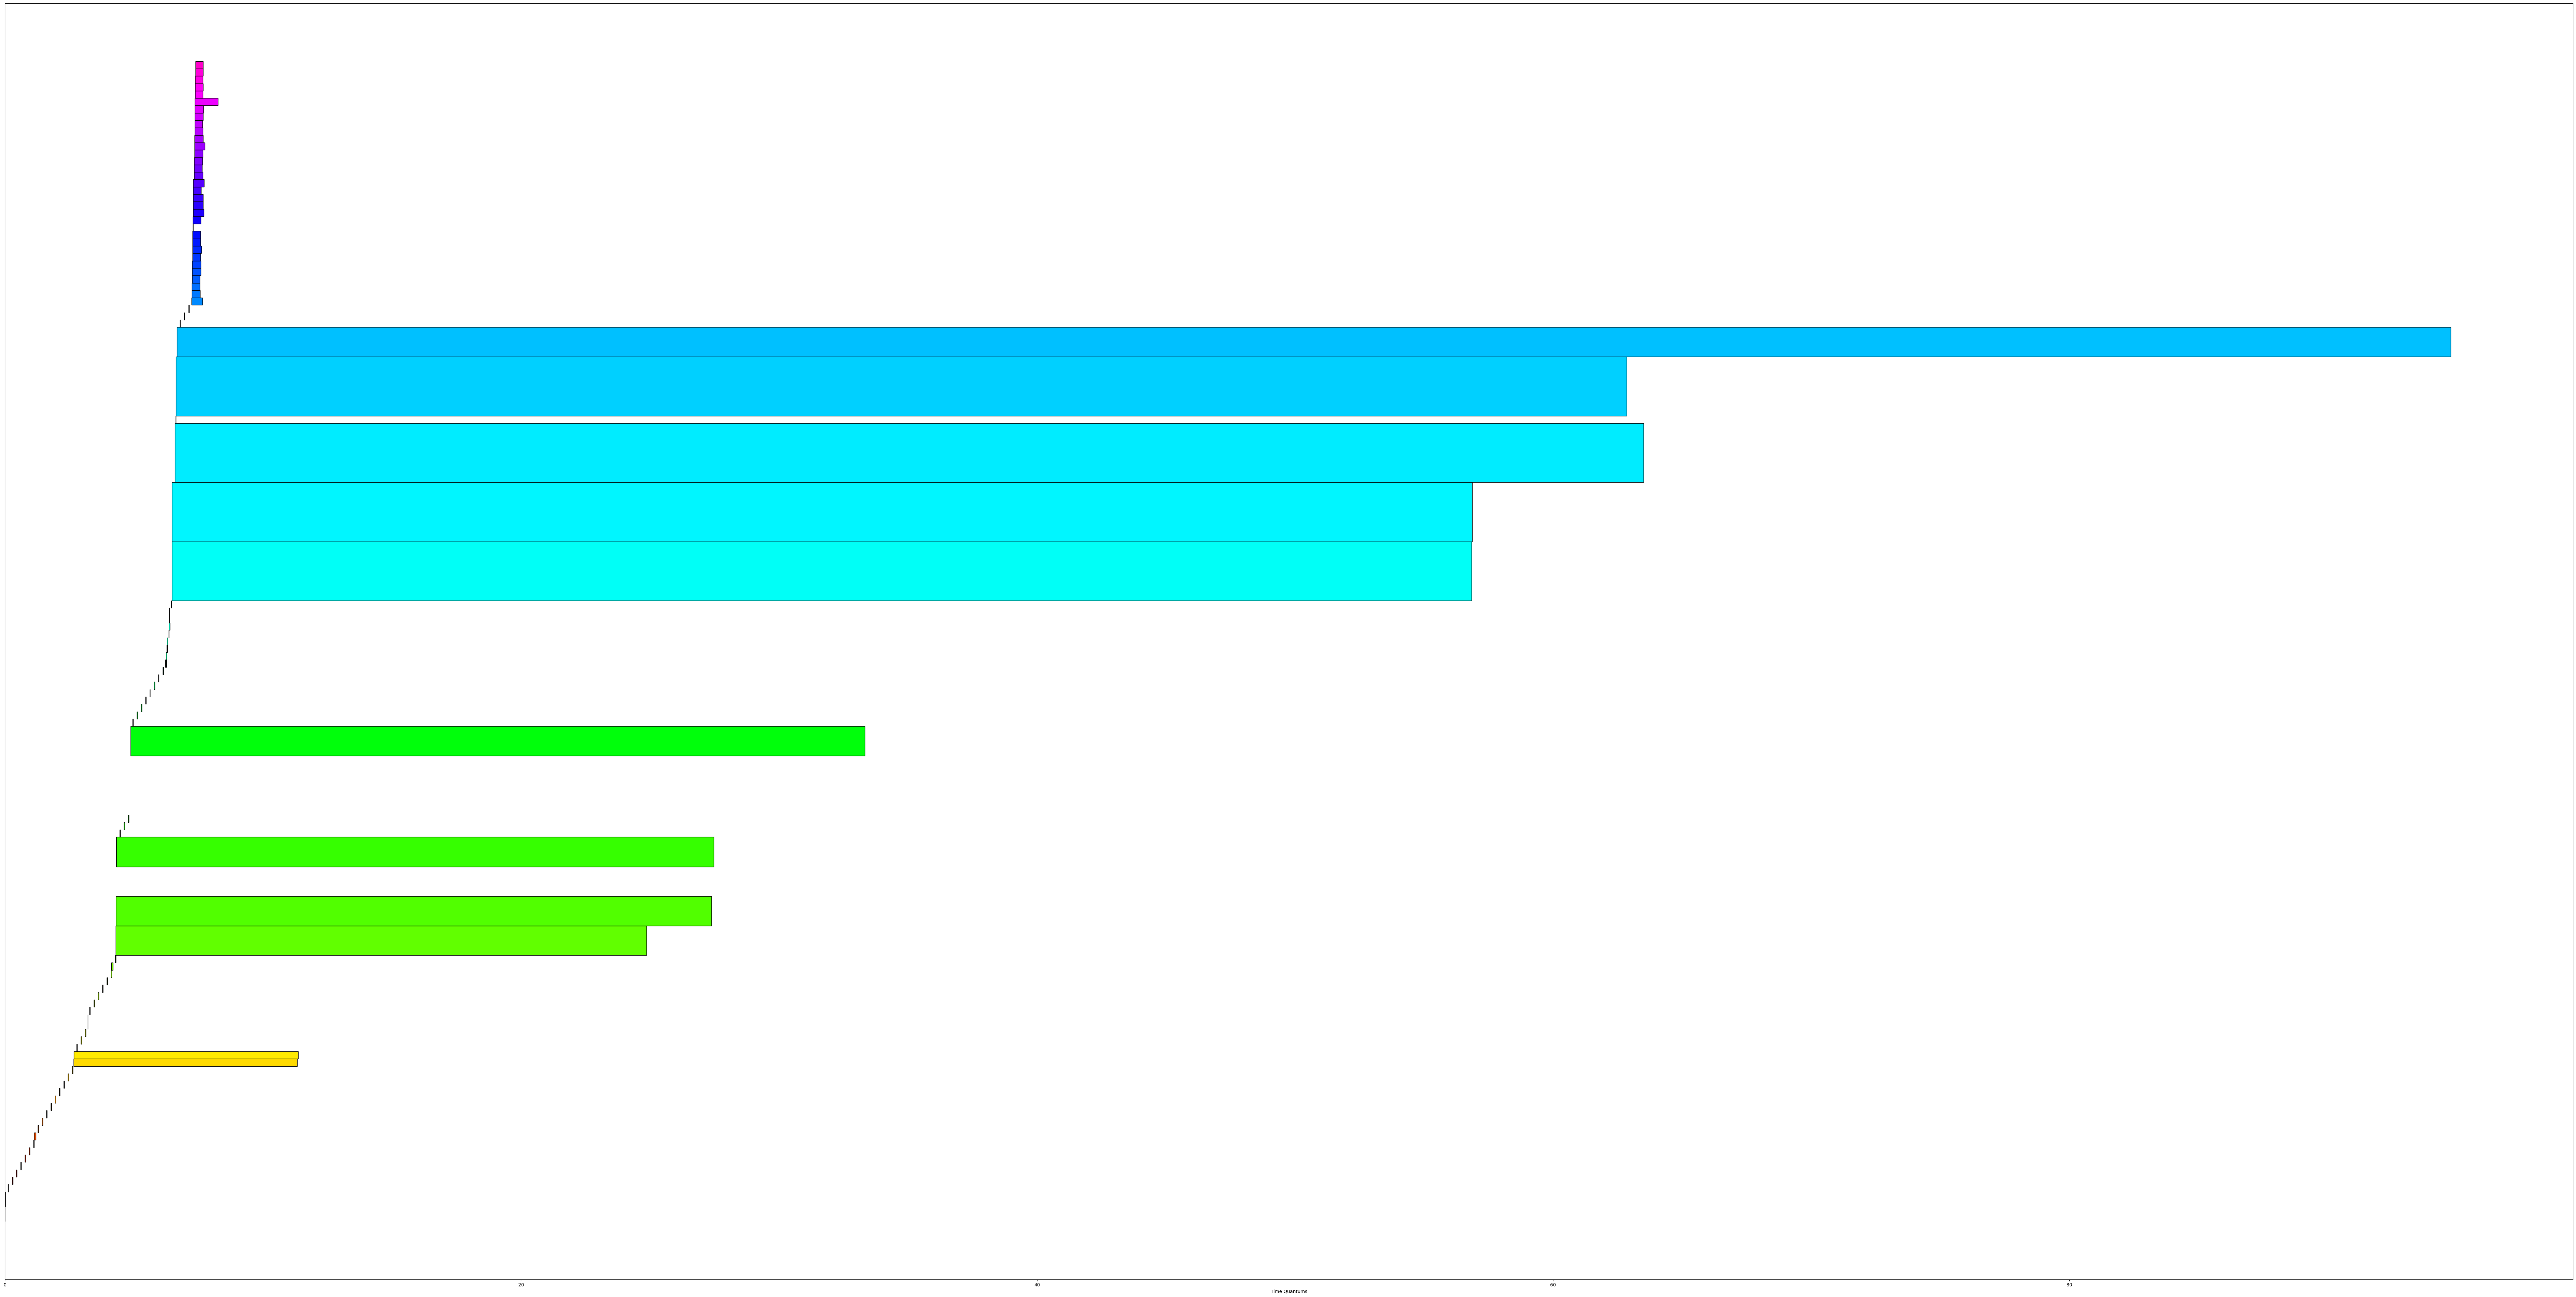

MILP-cloud


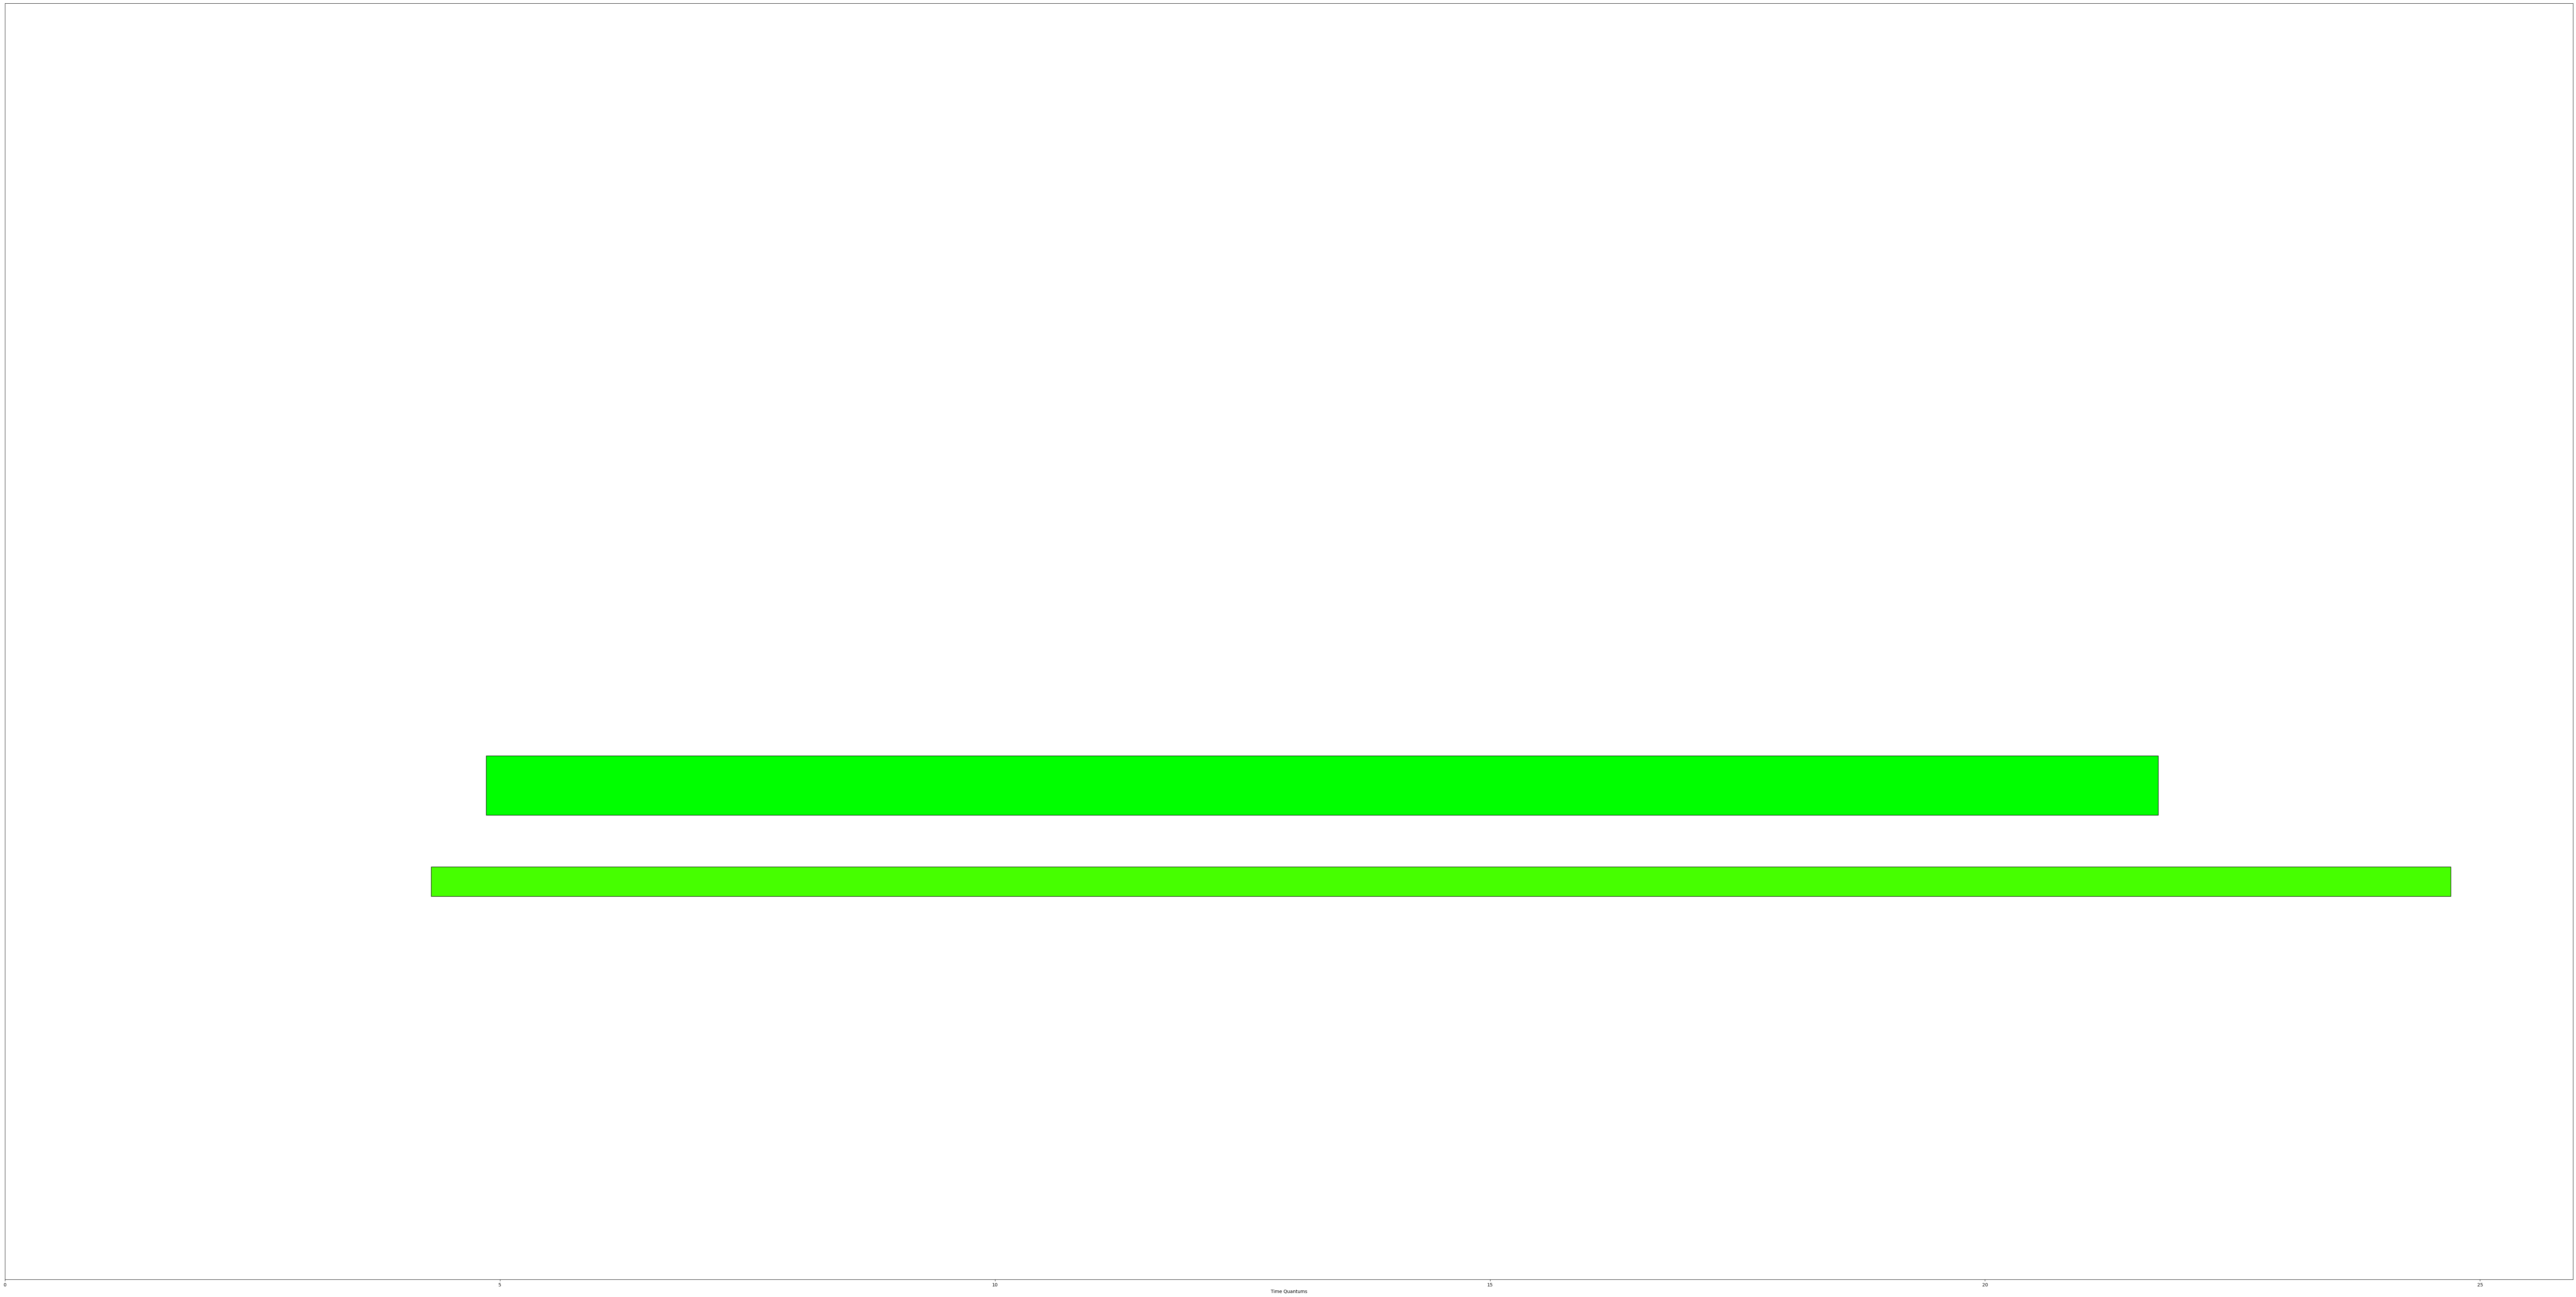

In [57]:
for job_filter in ['local', 'cloud']:
    print(f'MILP-{job_filter}')
    plot_qjob_runtimes(copy_jobs, mode=job_filter)